<a href="https://colab.research.google.com/github/Seungminin/DeepFake_detection_SING/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Resnext

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchvision.transforms.functional import to_tensor
from PIL import Image  # PIL의 Image 모듈을 import합니다.

import glob
import torch
import torchvision
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566170 sha256=0362ce3527befd0cf1071f07b97155ec5280ffdc93a8211925a6c631983152eb
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
import face_recognition

# Function to check if an image file is corrupted or not -> 필요없어졌는 지 check
def is_corrupted_image(image_path):
    try:
        _ = cv2.imread(image_path)
        return False
    except Exception as e:
        print(f"Corrupted image: {image_path}")
        return True

# Function to validate a list of image files -> 시간이 오래 걸려서 일단 생략.
def validate_images(image_paths, train_transforms):
    validated_images = []
    for image_path in image_paths:
        try:
            image = cv2.imread(image_path)
            if image is None:
                print(f"Invalid image: {image_path}")
                continue
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            pil_image = Image.fromarray(image)
            pil_image = train_transforms(pil_image)
            validated_images.append(pil_image)
        except Exception as e:
            print(f"Error processing image: {image_path}")
            continue
    return validated_images

def extract_file_names(data_list):
    desired_parts_list = []
    for file_path in data_list:
        parts = file_path.split('/')
        desired_parts = parts[5:] #/content/drive/MyDrive/datasets/valid/real/dsaass.jpg
        new_file_path = '/'.join(desired_parts)
        desired_parts_list.append(new_file_path)
    return desired_parts_list

# Constants and configurations
#im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define transformations
train_transforms = transforms.Compose([
    #transforms.Resize((im_size, im_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std) #표준화 이용. 이미지 정규화 하는 부분에서는 Normalization (0-1) 사이의 값, 혹은 Min-Max (-1,1) 사이의 값들을 이룬다.
])

# Paths to image directories, #list형태 사용
train_image_dirs = [
    '/content/drive/MyDrive/datasets/valid/real/',
    '/content/drive/MyDrive/datasets/valid/fake/'
]

test_image_dirs = [
    '/content/drive/MyDrive/datasets/test/real/',
    '/content/drive/MyDrive/datasets/test/fake/'
]

# Get list of all train image files
train_image_files = []  #image file들을 저장.(훈련 데이터만 저장을 한다)
for dir_path in train_image_dirs:
    train_image_files += glob.glob(os.path.join(dir_path, '*.jpg'))  # Assuming images are JPEG format

random.shuffle(train_image_files)
random.shuffle(train_image_files)

#Get list of all test image files
test_image_files = []  #image file들을 저장.(테스트 데이터만 저장을 한다)
for dir_path in test_image_dirs:
    test_image_files += glob.glob(os.path.join(dir_path, '*.jpg'))  # Assuming images are JPEG format

random.shuffle(test_image_files)
random.shuffle(test_image_files)

print("Total number of images:", len(train_image_files)) #train_image_files 2x10000
print("Total number of images:", len(test_image_files)) #test_image_files은 2x10000

# Validate images
#validated_images = validate_images(train_image_files, train_transforms) 시간이 너무 오래걸린다.

#print("Total number of validated images:", len(validated_images))

Total number of images: 20000
Total number of images: 20000


In [ ]:
# load the image name and labels from csv
class image_dataset(Dataset):
    def __init__(self,image_names,labels,transform = None):
        self.image_names = image_names
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = self.image_names[idx]
        parts = image_path.split('/')
        desired_parts = parts[5:]  # 5번째 이후의 부분을 가져옴
        new_file_path = '/'.join(desired_parts)
        label_info = self.labels.loc[self.labels['path'].values == new_file_path]

        label = 0  # Default label (혹시 라벨 정보가 없는 경우를 대비)
        if not label_info.empty:
            label_str = label_info['label_str'].values[0]
            if label_str == 'real':
                label = 1
            elif label_str == 'fake':
                label = 0

        # 이미지 불러오기
        image = Image.open(image_path)  # PIL 라이브러리를 사용해 이미지를 불러옴

        # 이미지를 텐서로 변환
        if self.transform:
            image = self.transform(image)

        return image, label

#plot the image
def im_plot(image):
    image = image.numpy().transpose((1, 2, 0))
    plt.imshow(image)
    plt.show()


In [ ]:
#count the number of fake and real videos, Because of random shuffle, there is difference.
def number_of_real_and_fake_videos(data_list, lab):
    if data_list == train_images or data_list == valid_images:
        real = 0
        fake = 0
        data_list = extract_file_names(data_list)
        for names in data_list:
          label_info = lab.loc[lab["path"].values == names]
           #해당하는 열의 정보를 label_info에 저장을 한다.
          if not label_info.empty:
            label_str = label_info['label_str'].values[0]  # 라벨 정보가 존재한다면 해당 이미지의 라벨 문자열 가져오기
            if label_str == 'real':
                real += 1
            elif label_str == 'fake':
                fake += 1
    else:
        real = 0
        fake = 0
        data_list = extract_file_names(data_list)
        for names in data_list:
          label_info = lab.loc[lab["path"].values == names]
          if not label_info.empty:
            label_str = label_info['label_str'].values[0]  # 라벨 정보가 존재한다면 해당 이미지의 라벨 문자열 가져오기
            if label_str == 'real':
                real += 1
            elif label_str == 'fake':
                fake += 1
    return real, fake

train :  16000
validation :  4000
test :  4000
TEST:  Real: 2013  Fake: 1987


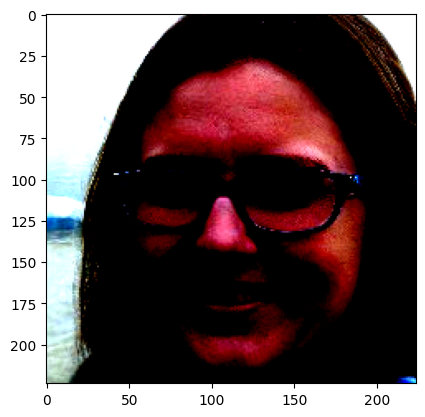

In [ ]:
# load the labels and video in data loader
import random
import pandas as pd
from sklearn.model_selection import train_test_split

header_list = ["number","original_path","id","label","label_str","path"] #우리의 csv파일에 맞게 label list형태를 변환.
label_train = pd.read_csv('/content/drive/MyDrive/datasets/labels/train.csv', names= header_list)
label_test = pd.read_csv('/content/drive/MyDrive/datasets/labels/test.csv', names = header_list)

#csv필요한 부분만 읽기.
label_train = label_train.drop(columns=["number", "original_path", "id"])
label_test = label_test.drop(columns=["number", "original_path", "id"])
#print(labels)
#train image, validation, test image 만드는 코드 (image_file에는 2만장 real, fake가 섞여있는 객체이고 2만장을 8:2로 각각 train : 16000, validation: 4000장)
#test image도 4천장 정도 만들어야 한다.

train_images = train_image_files[:int(0.8*len(train_image_files))] #처음부터 80%까지의 data를 저장
valid_images = train_image_files[int(0.8*len(train_image_files)):] #20% data는 validation image로 저장.
test_images = test_image_files[:int(0.2*len(test_image_files))] #20% 즉 4000장 정도 -> 나중에 train_test_split을 통해서 real과 fake의 비율을 맞추는 개선 활동 필요.

print("train : " , len(train_images))
print("validation : ", len(valid_images))
print("test : " , len(test_images))

#train_images,valid_images = train_test_split(image_files,test_size = 0.2)
#print(train_videos)
#real, fake = number_of_real_and_fake_videos(train_images,label_train)
#print("TRAIN: ", "Real:",real," Fake:",fake)

#real, fake = number_of_real_and_fake_videos(valid_images,label_train)
#print("VALIDATION: ", "Real:",real," Fake:",fake)

real, fake = number_of_real_and_fake_videos(test_images,label_test)
print("TEST: ", "Real:",real," Fake:",fake)

#전부 절반 정도 real, fake이미지를 가지고 있다.

#im_size = 224 #256/2, 최소 pretrained된 모델에 돌릴 때 들어가는 image의 height와 weight는 224*224
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        #transforms.ToPILImage(),
                                        #transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.CenterCrop(224), #Center Cropping을 통해 이미지 detection 성능을 올린다.
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        #transforms.ToPILImage(),
                                        #transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.CenterCrop(224),
                                        transforms.Normalize(mean,std)])

#train_dataset (return image와 label정보)
train_data = image_dataset(train_images,label_train,transform = train_transforms)
val_data = image_dataset(valid_images,label_train,transform = train_transforms)

#train dataloader
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2) #num_worker는 subprocess이다.
valid_loader = DataLoader(val_data, batch_size=4, shuffle=True, num_workers=2) #collate_fn=custom_collate_fn)
image,label = train_data[0]
im_plot(image)

In [ ]:
from torch import nn
from torchvision import models

class ImageModel(nn.Module):
    def __init__(self, num_classes):
        super(ImageModel, self).__init__()
        # Residual Network CNN
        model = models.resnext50_32x4d(pretrained=True)
        # 모든 레이어를 사용하지만 마지막 fully connected 레이어는 제외합니다.
        self.features = nn.Sequential(*list(model.children())[:-2])
        # AdaptiveAvgPool2d를 사용하여 특성 맵을 하나의 벡터로 압축합니다.
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        # 마지막 분류를 위한 Linear 레이어
        self.classifier = nn.Linear(2048, num_classes)
        # 활성화 함수와 드롭아웃을 추가합니다.
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)

    def forward(self, x):
        # 특성 추출
        x = self.features(x)
        x = self.avgpool(x)
        # Flatten
        x = x.view(x.size(0), -1)
        x = self.dp(self.relu(x))
        # 분류
        x = self.classifier(x)
        return x


In [ ]:
# 모델 초기화 (클래스 수를 예시로 2로 설정), real과 fake class 두개를 이용하기 때문/
model = ImageModel(2).cuda()

# 예시 이미지 데이터 생성 (여기서는 배치 크기를 1, 채널을 3, 이미지 크기를 224x224로 가정)
# 원본 코드에서는 (1, 20, 3, 112, 112) 차원이었으나, 이미지 모델에 맞게 (1, 3, 224, 224)로 조정
example_image = torch.from_numpy(np.empty((1, 3, 224, 224))).type(torch.cuda.FloatTensor)

# 모델에 이미지 데이터를 전달하여 예측 수행
output = model(example_image)

# 출력 확인 (필요한 경우)
print(output)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeXt50_32X4D_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth
100%|██████████| 95.8M/95.8M [00:00<00:00, 174MB/s]


tensor([[0.1783, 0.3054]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def calculate_accuracy(outputs, targets):
    _, preds = outputs.max(1)
    correct = preds.eq(targets).sum()
    acc = correct.float() / targets.size(0)
    return acc * 100


In [ ]:
import torch
from torch.autograd import Variable
import time
import os
import sys

def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            inputs, targets = inputs.cuda(), targets.cuda()

        outputs = model(inputs)
        loss = criterion(outputs, targets)
        acc = calculate_accuracy(outputs, targets).item()

        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        sys.stdout.write(
            "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]" %
            (epoch, num_epochs, i, len(data_loader), losses.avg, accuracies.avg)
        )
    # 모델 저장 경로 설정
    model_save_path = '/content/drive/MyDrive/datasets/checkpoint/checkpoint.pt'

    # 모델 저장 경로의 디렉토리 확인 및 생성
    model_save_dir = os.path.dirname(model_save_path)
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    torch.save(model.state_dict(), model_save_path)
    #이후 model을 load하는 방법.
    #model.load_state_dict(torch.load(model_save_path))
    return losses.avg, accuracies.avg

def test(epoch, model, data_loader, criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                inputs, targets = inputs.cuda(), targets.cuda()

            outputs = model(inputs)
            loss = criterion(outputs, targets)
            acc = calculate_accuracy(outputs, targets).item()

            _, p = torch.max(outputs, 1)
            true.extend(targets.cpu().numpy().tolist())
            pred.extend(p.cpu().numpy().tolist())

            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

            sys.stdout.write(
                "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]" %
                (i, len(data_loader), losses.avg, accuracies.avg)
            )
        print('\nAccuracy: {}'.format(accuracies.avg))
    return true, pred, losses.avg, accuracies.avg


In [ ]:
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Function to print the confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)  # Calculate confusion matrix
    print('True Positive = ', cm[0][0])  # True positive
    print('False Positive = ', cm[0][1])  # False positive
    print('False Negative = ', cm[1][0])  # False negative
    print('True Negative = ', cm[1][1])  # True negative
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4)  # Set label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16})  # Font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16, rotation=0)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
    print("Calculated accuracy: {:.2f}%".format(calculated_acc*100))

In [ ]:
def plot_loss(train_loss_avg, test_loss_avg, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_loss_avg, 'g-', label='Training Loss')
    plt.plot(epochs, test_loss_avg, 'b--', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_accuracy(train_accuracy, test_accuracy, num_epochs):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(10,6))
    plt.plot(epochs, train_accuracy, 'g-', label='Training Accuracy')
    plt.plot(epochs, test_accuracy, 'b--', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/5] [Batch 3998 / 4000] [Loss: 0.333799, Acc: 84.83%]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[Epoch 1/5] [Batch 3999 / 4000] [Loss: 0.333775, Acc: 84.84%]Testing
[Batch 999 / 1000]  [Loss: 0.074583, Acc: 98.00%]
Accuracy: 98.0
[Epoch 2/5] [Batch 3999 / 4000] [Loss: 0.207761, Acc: 91.63%]Testing
[Batch 999 / 1000]  [Loss: 0.052775, Acc: 98.62%]
Accuracy: 98.625
[Epoch 3/5] [Batch 3999 / 4000] [Loss: 0.163917, Acc: 93.49%]Testing
[Batch 999 / 1000]  [Loss: 0.053109, Acc: 98.42%]
Accuracy: 98.425
[Epoch 4/5] [Batch 3999 / 4000] [Loss: 0.130212, Acc: 94.39%]Testing
[Batch 999 / 1000]  [Loss: 0.028801, Acc: 99.53%]
Accuracy: 99.525
[Epoch 5/5] [Batch 3999 / 4000] [Loss: 0.063009, Acc: 98.04%]Testing
[Batch 999 / 1000]  [Loss: 0.024106, Acc: 99.38%]
Accuracy: 99.375


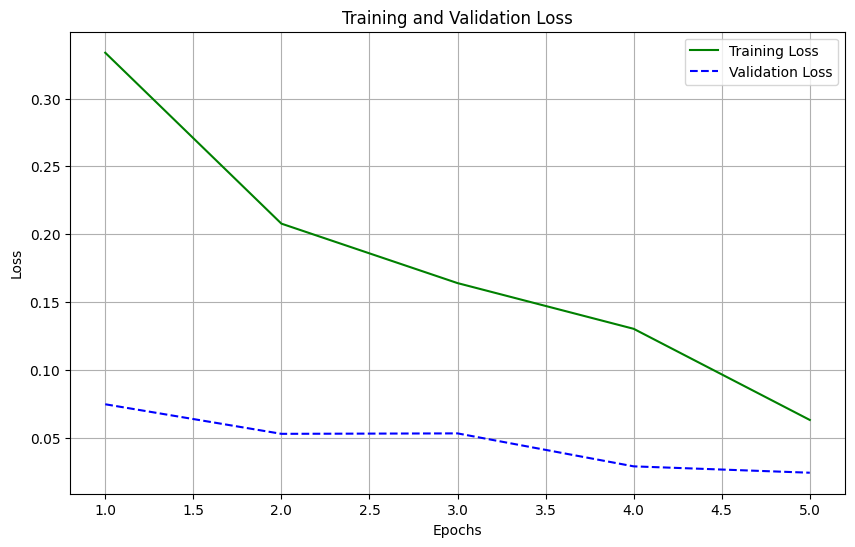

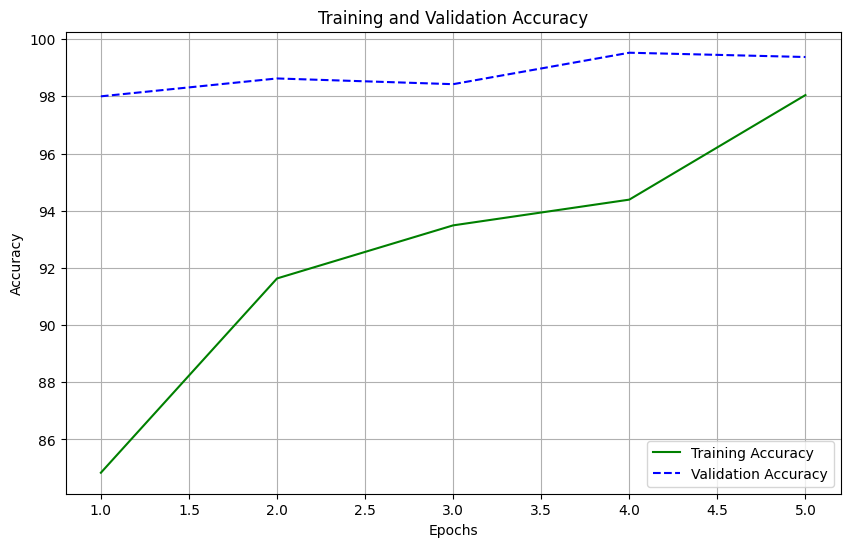

True Positive =  1989
False Positive =  19
False Negative =  6
True Negative =  1986




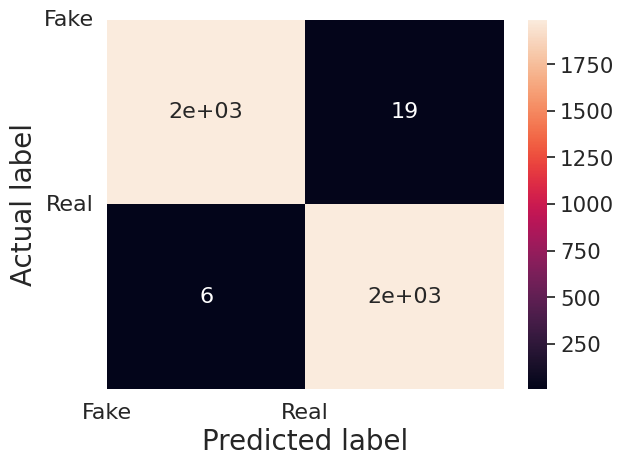

Calculated accuracy: 99.38%


In [ ]:
from sklearn.metrics import confusion_matrix
#learning rate
lr = 1e-5#0.001
#number of epochs
num_epochs = 5

optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-5)

#class_weights = torch.from_numpy(np.asarray([1,15])).type(torch.FloatTensor).cuda()
#criterion = nn.CrossEntropyLoss(weight = class_weights).cuda()
criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1, num_epochs+1):
    l, acc = train_epoch(epoch, num_epochs, train_loader, model, criterion, optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true, pred, tl, t_acc = test(epoch, model, valid_loader, criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)

plot_loss(train_loss_avg, test_loss_avg, num_epochs)
plot_accuracy(train_accuracy, test_accuracy, num_epochs)
print_confusion_matrix(true, pred)